<img src="https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/imagens/logo_nlportugues.png"   width="150" align="right">

# Lista 3 - Embeddings

______________


O objetivo desta lista é fazer com que vocês treinem um modelo de análise de sentimentos utilizando um embedding. O modelo final será criado na seção "montando o modelo", mas até lá vamos passar pelas seguintes etapas:  
 - Importando os dados como um dataframe
 - Pré Processamento
 - Separando em teste e treino
 - Tokenizando


Após montar e treinar seu modelo você tambem poderá fazer uma questão extra para ganhar nota extra nessa lista, deixar de fazer esse exercicio não prejudicará sua nota.



In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

2024-08-24 20:31:05.840061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 20:31:05.855892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 20:31:05.861283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 20:31:05.875255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 20:31:06.802751: W tensorflow/compiler/tf2

### Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [2]:
df = pd.read_csv('b2w-10k.csv')
df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN



### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar.
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend".

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [3]:
df = df[['review_text', 'recommend_to_a_friend']]
df['recommend_to_a_friend'] = df['recommend_to_a_friend'].map({'Yes': 1, 'No': 0})
df.dropna(subset=['review_text', 'recommend_to_a_friend'], inplace=True)
df

,review_text,recommend_to_a_friend
0,Estou contente com a compra entrega rápida o ú...,1
1,"Por apenas R$1994.20,eu consegui comprar esse ...",1
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1
4,"A entrega foi no prazo, as americanas estão de...",1
...,...,...
9994,"Celular muito rápido, com processador e armaze...",1
9995,"achei o produto muito frágil, o material veio ...",0
9996,Uma porcaria pois ñ recebi ñ recomendo pra nin...,0
9997,"Maquina excelente,super pratica. recomendo.ent...",1


### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [6]:
from sklearn.model_selection import train_test_split

max_features = 15000  # Limite de palavras no vocabulário
max_len = 50  # Baseado no histograma, ajustamos o comprimento dos reviews para 50 tokens

X_train, X_test, y_train, y_test = train_test_split(df['review_text'],
                                                    df['recommend_to_a_friend'],
                                                    test_size=0.25,
                                                    random_state=42)

print(f"Conjunto de treino: {len(X_train)} exemplos")
print(f"Conjunto de teste: {len(X_test)} exemplos")

Conjunto de treino: 7499 exemplos
Conjunto de teste: 2500 exemplos


### Tokenizando

Para alimentarmos os reviews a camada de embedding nós precisamos quebrar cada review em uma serie de tokens. Existem diversas maneiras de se realizar isso e poderiamos até mesmo usar outras bibliotecas como o spaCy.

Por exemplo, o objeto [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) oferece um método `tokenize` para quebrar as palavras em tokens individuais ao mesmo tempo que filtra caracteres indesejados (por default os caracteres filtrados são: !"#$\%&()*+,-./:;<=>?@[\\]^_\`{|}~\t\n).


Para essa lista utilizaremos a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) para automaticamente passar os reviews para caixa-baixa, extrair caracteres especiais e tokenizar as palavras de maneira a serem passadas para a camada de embedding. Ao tornarmos a etapa de tokenização uma camada de rede neural nós podemos incluir esse processamento dos reviews no proprio modelo.


## <font color='blue'>Questão 3 </font>
Utilizando a camada `TextVectorization` tokenize os inputs.
Declare a camada e então chame a função `adapt()` para adequar o seu vocabulário aos reviews.

Não se esqueça de se certificar que todas os reviews tenham o mesmo comprimento, seja por meio do uso de padding, truncamento ou uma mistura dos dois. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,  # Limite de palavras
    output_mode='int',  # Saída será uma sequência de inteiros
    output_sequence_length=max_len  # Comprimento fixo para todas as sequências
)

# Adaptar a camada ao vocabulário do conjunto de treino
vectorize_layer.adapt(X_train.values)

# Aplicar a tokenização e o padding/truncamento no conjunto de treino e teste
X_train_vectorized = vectorize_layer(X_train.values)
X_test_vectorized = vectorize_layer(X_test.values)

# Verificação dos shapes (tamanho) das entradas após tokenização
print(f"Tamanho do conjunto de treino tokenizado: {X_train_vectorized.shape}")
print(f"Tamanho do conjunto de teste tokenizado: {X_test_vectorized.shape}")

Tamanho do conjunto de treino tokenizado: (7499, 50)
Tamanho do conjunto de teste tokenizado: (2500, 50)


### Montando o modelo

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

##  <font color='blue'>Questão 4 </font>

Defina seu modelo.

Como analise de sentimentos pode ser visto como um problema de classificação, é interessante também registrar algumas métricas como acurácia `metrics=["acc"]` .

Seu modelo deve começar com a seguinte estrutura:
 - Camada de Input
 - Camada de Tokenização
 - Camada de Embedding

Já definimos as camadas seguintes da rede por você.

Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers

# Definindo o número de palavras e a dimensão dos embeddings
vocab_size = max_features + 1  # Incluímos +1 para lidar com tokens <PAD> e <OOV>
embedding_dim = 100  # Você pode ajustar a dimensão dos embeddings conforme necessário
input_length = max_len  # O comprimento de cada sequência (número fixo de tokens)

# Definindo o modelo
model = tf.keras.Sequential([
    # Camada de Input
    layers.Input(shape=(input_length,)),

    # Camada de Embedding
    layers.Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     input_length=input_length),

    # Conv1D + Global Max Pooling
    layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3),
    layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3),
    layers.GlobalMaxPooling1D(),

    # Camadas densas para classificação
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid para classificação binária
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Classificação binária
              metrics=['accuracy'])  # Registrando acurácia

# Resumo do modelo
model.summary()

/home/hub/COURSERA/NLP/nlp/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     1,500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 15, 128)        │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 128)         │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721,285 (6.57 MB)

 Trainable params: 1,721,285 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

### Treinando e avaliando seu modelo

##  <font color='blue'>Questão 5 </font>

Com seu modelo definido, treine e avalie sua performance no conjunto de testes.



In [10]:
history = model.fit(X_train_vectorized, y_train, epochs=5, batch_size=32, validation_data=(X_test_vectorized, y_test))

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9942 - loss: 0.0162 - val_accuracy: 0.8752 - val_loss: 0.5954
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9980 - loss: 0.0079 - val_accuracy: 0.8768 - val_loss: 0.6823
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 0.8596 - val_loss: 1.0420
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9968 - loss: 0.0095 - val_accuracy: 0.8608 - val_loss: 0.9144
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9977 - loss: 0.0082 - val_accuracy: 0.8372 - val_loss: 1.1258


In [11]:
test_loss, test_accuracy = model.evaluate(X_test_vectorized, y_test)
print(f"Acurácia no conjunto de teste: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8405 - loss: 1.0954
Acurácia no conjunto de teste: 0.8371999859809875


##  <font color='green'>Questão Extra </font>

### Vizualizando o embedding
Agora que temos um embedding treinado em nossa tarefa de analise de sentimentos, podemos tentar vizualisar este embedding. O [embedding projector](https://projector.tensorflow.org/) nos permite visualiza-los de maneira mais intuitiva.

Para carregar seu próprio embedding você precisará fornecer 2 arquivos, um com os embeddings propriamente ditos e outro com os métadados (no nosso caso, um string que representa a palavra).


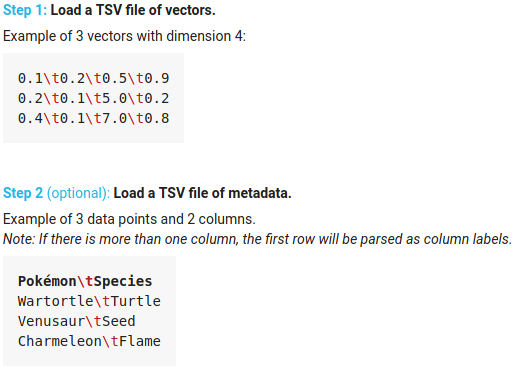

Esse [guia](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) pode ser util para entender melhor como extrair essas informações.

Procure por palavras com conotações tradicionalmente positivas e negativas, elas estão proximas ou distantes?
Usando a visualização PCA, você consegue notar alguma característica interessante sobre como as palavras estão distribuidas nesse espaço?

In [14]:
# Caminhos dos arquivos TSV para salvar os embeddings e metadados
embedding_file_path = 'embedding_vectors.tsv'
metadata_file_path = 'embedding_metadata.tsv'

# Obter os pesos da camada de embedding do modelo treinado
embedding_weights = model.layers[0].get_weights()[0]

# Obter o vocabulário da camada TextVectorization
vocab = vectorize_layer.get_vocabulary()  # Retorna a lista de palavras no vocabulário
word_index = {word: index for index, word in enumerate(vocab)}

# Escrever os embeddings e os metadados nos arquivos TSV
with open(embedding_file_path, 'w', encoding='utf-8') as f_vectors, open(metadata_file_path, 'w', encoding='utf-8') as f_metadata:
    for word, i in word_index.items():
        if i < len(embedding_weights):  # Verifica se o índice i está dentro dos limites da matriz de embeddings
            embedding_vector = embedding_weights[i]
            if embedding_vector is not None:
                # Escreve os vetores de embedding no arquivo
                f_vectors.write('\t'.join([str(x) for x in embedding_vector]) + '\n')
                # Escreve as palavras correspondentes no arquivo de metadados
                f_metadata.write(word + '\n')
        else:
            print(f"Ignorando o índice {i}, fora dos limites da matriz de embeddings.")

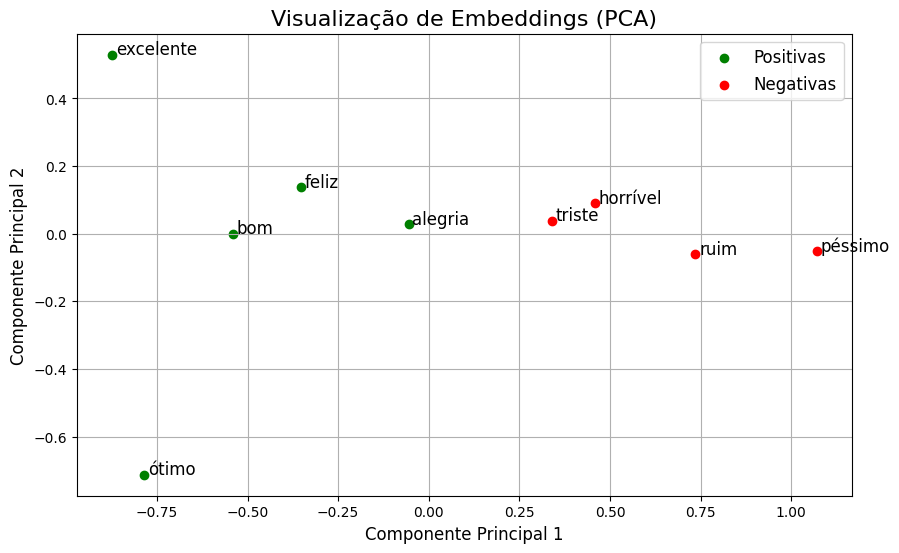

In [15]:
from sklearn.decomposition import PCA

# Definir as palavras e seus respectivos vetores de embeddings (já extraídos)
palavras_positivas = ['bom', 'excelente', 'ótimo', 'feliz', 'alegria']
palavras_negativas = ['ruim', 'horrível', 'péssimo', 'triste']

# Embeddings das palavras (substitua pelos embeddings reais)
vetores_positivos = [embedding_weights[word_index[word]] for word in palavras_positivas]
vetores_negativos = [embedding_weights[word_index[word]] for word in palavras_negativas]

# Juntar os vetores
vetores = np.array(vetores_positivos + vetores_negativos)

# Aplicar PCA para reduzir para 2D
pca = PCA(n_components=2)
vetores_reduzidos = pca.fit_transform(vetores)

# Separar os vetores reduzidos em positivos e negativos
vetores_positivos_reduzidos = vetores_reduzidos[:len(vetores_positivos)]
vetores_negativos_reduzidos = vetores_reduzidos[len(vetores_positivos):]

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.scatter(vetores_positivos_reduzidos[:, 0], vetores_positivos_reduzidos[:, 1], color='green', label='Positivas')
plt.scatter(vetores_negativos_reduzidos[:, 0], vetores_negativos_reduzidos[:, 1], color='red', label='Negativas')

# Adicionar labels para as palavras
for i, word in enumerate(palavras_positivas):
    plt.text(vetores_positivos_reduzidos[i, 0] + 0.01, vetores_positivos_reduzidos[i, 1], word, fontsize=12)
for i, word in enumerate(palavras_negativas):
    plt.text(vetores_negativos_reduzidos[i, 0] + 0.01, vetores_negativos_reduzidos[i, 1], word, fontsize=12)

# Configurações do gráfico
plt.title('Visualização de Embeddings (PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Mostrar o gráfico
plt.show()

**Conclusão:**
O modelo conseguiu capturar as relações semânticas entre palavras de conotações semelhantes. Palavras positivas estão agrupadas e separadas das palavras negativas no espaço de embeddings, o que é um bom indicador de que o modelo aprendeu a diferenciar corretamente o significado das palavras com base em sua polaridade emocional.